# Linear Models for Classification

This chapter is about performing classification using linear discriminant functions. The discriminant functions are constructed by using a simple linear model $f(x) = w^Tx + w_0$ and setting all values of x to 0 where $f(x) > 0$. The boundary is where $f(x)$ = 0, i.e. where the weight matrix $W^Tx = 0$. For this reason the decision boundary will always be orthogonal to the weight matrix. For $K$ class classification we try to fit such a weight matrix k times. Different than with linear regresiion we now have a one-hot vector $t$ which we regress onto the input matrix.  Since we want to find a matrix that maps the data points from x closest to t we basically are trying to find the inverse from x on t since that would give us W. This can be done using the pseudo-inverse (since x usually isnt square) and is defined as 

$$
    W = (X^TX)^{-1}X^TT
$$

Just as with simple linear regression. The fit of the model can subsequently be determined by the sum of squared, which is equivalent to claculating the trace of the square matrix

$$
   E_D(W) = \frac{1}{2} Tr\{(XW - T)^T(XW -T)\}
$$

In [72]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [73]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3)

In [74]:
df = pd.DataFrame(np.concatenate([X, y.reshape(-1, 1)], axis=1))
df.columns = ['x1', 'x2', 'label']

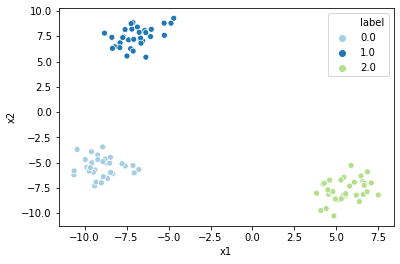

In [75]:
sns.scatterplot(x='x1', y='x2', hue='label', data=df, palette="Paired")
plt.show()

In [76]:
# Augment  the matrix X such that the bias is included in the matrix multiplication
X = np.concatenate([np.ones((100, 1)), X], axis=1)
# Create one-hot matrix of the target label
T = pd.get_dummies(y).values

In [77]:
# Calculate the Morgan-Penrose pseudo inverse
W = np.linalg.inv(X.T @ X) @ X.T @ T
print(W.shape)

(3, 3)


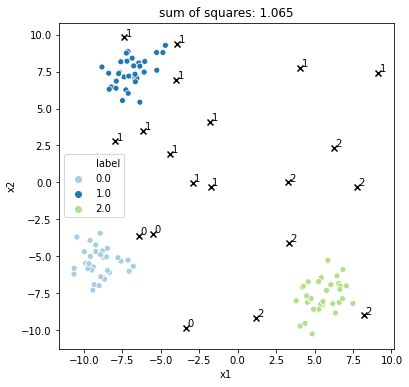

In [152]:
# To show that it works, sample 20 new test datapoints and assign to the max value after the linear transformation
X_test = np.random.uniform(-10, 10, (2, 20))
X_test = np.concatenate([np.ones((1, 20)), X_test], axis=0)
predictions = np.argmax(W.T @ X_test, axis=0)

# Calculate the sum of squares error
sum_of_squares = (1 / 2) * np.trace(((X @ W) - T).T @ ((X @ W) - T))

plt.figure(figsize=(6, 6))
plt.title(f'sum of squares: {sum_of_squares.round(3)}')
sns.scatterplot(x='x1', y='x2', hue='label', data=df, palette="Paired")
for index, label in enumerate(np.unique(predictions)):
    subset = X_test.T[predictions == label]
    plt.scatter(subset[:,1], subset[:,2], c='black', marker='x')
    
    for item in subset:
        plt.text(item[1] + 0.1, item[2] + 0.1, label)
    
plt.show()

In [156]:
probabilities = (W.T @ X_test).T

In [157]:
probabilities.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [162]:
probabilities[probabilities > 1.0]

array([1.04643541, 1.17796475, 1.15147272, 1.11292946, 1.13833383,
       1.04498591, 1.15072472])

In [163]:
probabilities[probabilities < 0.0]

array([-0.60480545, -0.65390699, -0.28844075, -0.10670913, -0.07125562,
       -0.31926043, -0.16828574, -0.82353208, -0.24929212, -1.18331974,
       -0.15348783, -0.15928101, -0.08842122, -0.0623035 , -0.01737338,
       -0.0426855 ])

As you can see the probabilities do sum to 1, however not all scores are $\in [0,1]$ so this type of classification will not result in a valid probability distribution

## Fisher linear discriminant

To account for these problems you can for example use a fisher linear discriminant. What you basically do with classification is performing feature reduction into a single number. This can ofcourse not give good results. Using the Fisher discriminant you try to find a mapping that maximizes the inter-class variance and minimize the intra-class variacne (i.e. seperate clusters as good as possible but keep similar items close)